In [1]:
import tomotopy as tp
import numpy as np
import pandas as pd
import re
import os
import time
import itertools
import konlpy
from kiwipiepy import Kiwi
from hanspell import spell_checker
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pyLDAvis


In [2]:
df=pd.read_csv('leisure2.csv',encoding='utf-8-sig',header=0, dtype={'score':np.str})
df.info()

C:\Users\jenny\AppData\Local\Temp/ipykernel_12104/1705503032.py:1: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df=pd.read_csv('leisure2.csv',encoding='utf-8-sig',header=0, dtype={'score':np.str})


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12029 entries, 0 to 12028
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    12029 non-null  int64 
 1   real_date     12029 non-null  object
 2   year          12029 non-null  int64 
 3   month         12029 non-null  int64 
 4   type          10567 non-null  object
 5   review_title  12029 non-null  object
 6   review        12029 non-null  object
 7   score         12029 non-null  object
 8   dataset       11869 non-null  object
dtypes: int64(3), object(6)
memory usage: 845.9+ KB


In [3]:
df['type'].unique()

array([' 커플', ' 개인', ' 가족', ' 친구', ' 비지니스', nan], dtype=object)

In [4]:
for i in range(len(df)):
    if df.iloc[i,4] in [' 친구',' 가족',' 커플']:
        df.iloc[i,4] = 'no_solo'
    elif df.iloc[i,4] in [' 비지니스', np.NaN]:
        df.iloc[i,4] = np.NaN
    elif df.iloc[i,4] in [' 개인']:
        df.iloc[i,4]='solo'

In [5]:
df['type'].unique()

array(['no_solo', 'solo', nan], dtype=object)

In [6]:
df.dropna(subset=['type'], how='any', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9962 entries, 0 to 12028
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    9962 non-null   int64 
 1   real_date     9962 non-null   object
 2   year          9962 non-null   int64 
 3   month         9962 non-null   int64 
 4   type          9962 non-null   object
 5   review_title  9962 non-null   object
 6   review        9962 non-null   object
 7   score         9962 non-null   object
 8   dataset       9816 non-null   object
dtypes: int64(3), object(6)
memory usage: 778.3+ KB


In [7]:
#솔로/비솔로 데이터 구분
#솔로
condition = (df.type=='no_solo')
df2=df.loc[condition]

In [8]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8249 entries, 0 to 12028
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    8249 non-null   int64 
 1   real_date     8249 non-null   object
 2   year          8249 non-null   int64 
 3   month         8249 non-null   int64 
 4   type          8249 non-null   object
 5   review_title  8249 non-null   object
 6   review        8249 non-null   object
 7   score         8249 non-null   object
 8   dataset       8128 non-null   object
dtypes: int64(3), object(6)
memory usage: 644.5+ KB


In [9]:
df2.dropna(subset=['dataset'], how='any', inplace=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8128 entries, 0 to 12028
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    8128 non-null   int64 
 1   real_date     8128 non-null   object
 2   year          8128 non-null   int64 
 3   month         8128 non-null   int64 
 4   type          8128 non-null   object
 5   review_title  8128 non-null   object
 6   review        8128 non-null   object
 7   score         8128 non-null   object
 8   dataset       8128 non-null   object
dtypes: int64(3), object(6)
memory usage: 635.0+ KB


C:\Users\jenny\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [10]:
#응집도 계산 전 사용할 토크나이저 함수 정의

import konlpy
stop_list=['우리','함께','있습니다']
def tokenize_korean_text(text):
    text = re.sub(r'[^,.?!\w\s]','', text)
    
    okt = konlpy.tag.Okt()
    Okt_morphs = okt.pos(text)
    
    words = []
    for word, pos in Okt_morphs:
        if not pos == 'Josa' and not pos =='Punctuation' and not pos =='Foreign' and len(word) > 1 and word not in stop_list :
            words.append(word)
    ## word를 이어붙인 string 형태가 아닌 word의 list를 return해주는 게 sklearn lda 준비 과정과의 차이
            
    return words

In [11]:
#솔로 데이터 토큰화
tokenized_list_no = []
a=df2['dataset'].values
for text in range(len(a)):
    tokenized_list_no.append(tokenize_korean_text(a[text]))

In [12]:
#솔로
model = tp.DMRModel(k=20, alpha=0.1, eta=0.01, min_cf=3,rm_top=3,tw=tp.TermWeight.IDF)

key=df2['score'].values
value=tokenized_list_no


for pairs in zip(key, value):
    try :
        model.add_doc(pairs[1],metadata=pairs[0]) # tokenize함수를 이용해 전처리한 결과를 add_doc에 넣습니다.
    except RuntimeError :
        pass
        
               
model.train(0)
print('Total docs:', len(model.docs))
print('Total words:', model.num_words)
print('Vocab size:', model.num_vocabs)
 

Total docs: 8128
Total words: 212041
Vocab size: 5980


In [13]:
model.summary()

<Basic Info>
| DMRModel (current version: 0.12.2)
| 8128 docs, 212041 words
| Total Vocabs: 16664, Used Vocabs: 5980
| Entropy of words: 7.19274
| Entropy of term-weighted words: 7.81201
| Removed Vocabs: 있는 좋은 서울
| Metadata of docs and its distribution
|  5: 4032
|  4: 3055
|  3: 913
|  2: 100
|  1: 28
|
<Training Info>
| Iterations: 0, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -10.61094
|
<Initial Parameters>
| tw: TermWeight.IDF
| min_cf: 3 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 3 (the number of top words to be removed)
| k: 20 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (an initial value of exponential of mean of normal distribution for `lambdas`, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic - word)
| sigma: 1.0 (standard deviation of norma

==== Coherence : c ====
Average: 0.37306130850571206 
Per Topic: [0.3825239211320877, 0.30469024628400804, 0.4028746792813763, 0.3488425612449646, 0.4083853095769882, 0.3640001766383648, 0.3705336734652519, 0.41031710654497144, 0.3749296128749847, 0.3650775983929634, 0.40951028317213056, 0.33726796619594096, 0.3851757600903511, 0.3132634162902832, 0.3867073869332671, 0.40230110883712766, 0.33082379326224326, 0.3908406987786293, 0.3859031558036804, 0.3872577153146267]


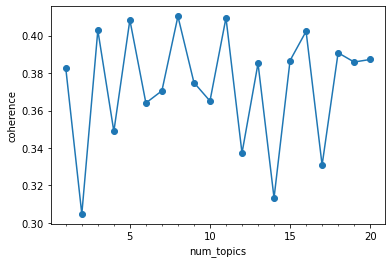

In [14]:
# calculate coherence using preset
ax=plt.axes()
coh = tp.coherence.Coherence(model, coherence='c_v')
average_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(model.k)]
print('==== Coherence : c ====')
print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
x=range(1,21,1)
plt.plot(x, coherence_per_topic,marker='o')
plt.xlabel("num_topics")
plt.ylabel("coherence")
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.show()
print()

In [15]:
#토픽수 정하고 솔로 분석
model = tp.DMRModel(k=3, alpha=0.1, eta=0.01, min_cf=3,rm_top=3,tw=tp.TermWeight.IDF)

key=df2['score'].values
value=tokenized_list_no

for pairs in zip(key, value):
    try :
        model.add_doc(pairs[1],metadata=pairs[0]) # tokenize함수를 이용해 전처리한 결과를 add_doc에 넣습니다.
    except RuntimeError :
        pass

model.train(0)
print('Total docs:', len(model.docs))
print('Total words:', model.num_words)
print('Vocab size:', model.num_vocabs)
 
 
 
for i in range(200):
    model.train(1)
    
for i in range(model.k):
    res = model.get_topic_words(i, top_n=10)
    print('Topic #{}'.format(i), end='\t')
    print(', '.join(w for w, p in res))

Total docs: 8128
Total words: 212041
Vocab size: 5980
Topic #0	궁전, 아름다운, 방문, 투어, 한국, 역사, 시간, 팰리스, 건물, 많은
Topic #1	한강, 좋아요, 너무, 공원, 산책, 야경, 도심, 입니다, 청계천, 좋습니다
Topic #2	타워, 전망, 케이블카, 타고, 버스, 도시, 멋진, 사랑, 남산, 공원


In [16]:
model.summary()

<Basic Info>
| DMRModel (current version: 0.12.2)
| 8128 docs, 212041 words
| Total Vocabs: 16664, Used Vocabs: 5980
| Entropy of words: 7.19274
| Entropy of term-weighted words: 7.81201
| Removed Vocabs: 있는 좋은 서울
| Metadata of docs and its distribution
|  5: 4032
|  4: 3055
|  3: 913
|  2: 100
|  1: 28
|
<Training Info>
| Iterations: 200, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -7.74844
|
<Initial Parameters>
| tw: TermWeight.IDF
| min_cf: 3 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 3 (the number of top words to be removed)
| k: 3 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (an initial value of exponential of mean of normal distribution for `lambdas`, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic - word)
| sigma: 1.0 (standard deviation of norma

In [17]:
#솔로 감성점수 계산
print('Topic distributions by score, solo')

df4=pd.DataFrame()
score_labels=['1','2','3','4','5']

for i in score_labels:
    df4[i+'score']=model.get_topic_prior(i)
df4['total']=df4.sum(axis=1)

total_sum=df4['total'].values
gamsung_sum=0
gamsung_list=[]

for i in range(model.k):
    a=df4.iloc[i,:-1].values
    gamsung_sum=(a[0]*1+a[1]*2+a[2]*3+a[3]*4+a[4]*5)/total_sum[i]
    gamsung_list.append(gamsung_sum)
    
df4['re_score']=gamsung_list
df4.head(20)

Topic distributions by score, solo


,1score,2score,3score,4score,5score,total,re_score
0,0.029496,0.088828,0.186072,0.244194,0.149836,0.698426,3.567056
1,0.106252,0.539465,0.089847,0.129454,0.074586,0.939604,2.496232
2,0.294081,0.156456,0.095731,0.165697,0.098308,0.810272,2.528177


In [18]:
#각 토픽 별 상위 10개 단어 추출
word_list=[]
for i in range(model.k):
    a=model.get_topic_words(i, top_n=10)
    word_list.append([x[0] for x in a])

df4['word_list']=word_list
df4.head(15)

,1score,2score,3score,4score,5score,total,re_score,word_list
0,0.029496,0.088828,0.186072,0.244194,0.149836,0.698426,3.567056,"[궁전, 아름다운, 방문, 투어, 한국, 역사, 시간, 팰리스, 건물, 많은]"
1,0.106252,0.539465,0.089847,0.129454,0.074586,0.939604,2.496232,"[한강, 좋아요, 너무, 공원, 산책, 야경, 도심, 입니다, 청계천, 좋습니다]"
2,0.294081,0.156456,0.095731,0.165697,0.098308,0.810272,2.528177,"[타워, 전망, 케이블카, 타고, 버스, 도시, 멋진, 사랑, 남산, 공원]"


In [19]:
 # extract candidates for auto topic labeling
extractor = tp.label.PMIExtractor(min_cf=5, min_df=5, max_len=5, max_cand=10000, normalized=True)
cands = extractor.extract(model)

labeler = tp.label.FoRelevance(model, cands, min_df=5, smoothing=1e-2, mu=0.25)
for k in range(model.k):
    print("== Topic #{} ==".format(k))
    print("Labels:", ', '.join(label for label, score in labeler.get_topic_labels(k, top_n=5)))
    for word, prob in model.get_topic_words(k, top_n=10):
        print(word, prob, sep='\t')
    print()

== Topic #0 ==
Labels: 팰리스, 궁전, 가이드, 영어, 투어
궁전	0.007291365880519152
아름다운	0.0061088320799171925
방문	0.005989737343043089
투어	0.0057149664498865604
한국	0.005483351182192564
역사	0.005447895731776953
시간	0.005257850978523493
팰리스	0.005101337097585201
건물	0.004951192997395992
많은	0.004927217494696379

== Topic #1 ==
Labels: 좋아요, 도심, 같아요, 다만 주말, 데이트
한강	0.00725347688421607
좋아요	0.007018682546913624
너무	0.005803179461508989
공원	0.005603605881333351
산책	0.005409713368862867
야경	0.005145154893398285
도심	0.004744945093989372
입니다	0.004701399244368076
청계천	0.004624018445611
좋습니다	0.0043707904405891895

== Topic #2 ==
Labels: 타워, 케이블카, 타고, 전망, 케이블
타워	0.01673901453614235
전망	0.011057371273636818
케이블카	0.009275693446397781
타고	0.007990209385752678
버스	0.006595817860215902
도시	0.005927341990172863
멋진	0.005853669252246618
사랑	0.0053087021224200726
남산	0.00511753186583519
공원	0.0048339152708649635



In [20]:
#빈도 구하기 전
df5=pd.DataFrame()
df5['docs']=tokenized_list_no
df5['score']=df2['score'].values
df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   docs    8128 non-null   object
 1   score   8128 non-null   object
dtypes: object(2)
memory usage: 127.1+ KB


In [21]:
#빈도 구하기

topic_num=[]
temp1=[] #토픽번호
temp2=[] #분포율
for i in range(len(model.docs)):
    a=model.docs[i].get_topics()
    temp1.append([x[0] for x in a])
    temp2.append([x[1] for x in a])
for i in range(len(temp1)):
    if temp2[i][0] >= 0.5:
        topic_num.append(temp1[i][0])
    else :
        topic_num.append(np.NaN)
df5['topic_num']=topic_num
df5[df5['topic_num'].isnull()]

,docs,score,topic_num
2,"[나들이, 하기, 좋은, 가끔, 어머니, 산책, 하러, 갑니다, 향원정, 너무, 이...",4,NaN
126,"[봐야, 하는, 궁전, 혼잡, 이유, 있나, 건축, 아름다우면서, 세부, 심압, 대...",4,NaN
177,"[놀라운, 정말, 놀라운, 역사, 애호가, 관광객, 시간, 자연, 가깝습니다, 풍경...",5,NaN
687,"[외국인, 친구, 가기, 좋은, 가장, 한국, 이기, 때문, 외국인, 친구, 아주,...",5,NaN
810,"[멋진, 장소, 다른, 야간, 개장, 주는, 다른, 매력, 때마침, 내린, 비는, ...",5,NaN
...,...,...,...
7690,"[좋아하는, 서울, 좋아하는, 서울, 입니다, 아주, 사랑스러운, 가을, 비원, 이...",5,NaN
7699,"[편안한, 지하철, 수인, 종로구, 근처, 머물, 경우, 걸어갈, 있는, 아침, 추...",4,NaN
7741,"[역사, 알기, 궁궐, 지킴, 이의, 설명, 들으며, 역사, 다시, 생각, 하게, ...",5,NaN
7767,"[사랑스러운, 궁전, 위대한, 도보, 예의, 많은, 궁전, 유사한, 조금, 다른, ...",5,NaN


In [22]:
df6=df5.groupby(['topic_num','score'])['docs']
print(df6.size().reset_index(name='counts'))

    topic_num score  counts
0         0.0     1      12
1         0.0     2      43
2         0.0     3     388
3         0.0     4    1350
4         0.0     5    1773
5         1.0     1       6
6         1.0     2      29
7         1.0     3     229
8         1.0     4     873
9         1.0     5    1372
10        2.0     1       9
11        2.0     2      23
12        2.0     3     268
13        2.0     4     748
14        2.0     5     799
